In [ ]:
!pip install gdown

#Download file training dan validasi dari Google Drive menggunakan file ID
!gdown --id 1oiBeWGLWatDOIj75J7MNP_EQmG_EPxek -O Dataset_pH_Bunga_Telang_Train.zip
!gdown --id 1l9ibha0S-l-36ZFR-rFkV7IftWoyR5uD -O Dataset_pH_Bunga_Telang_Validation.zip

#Ekstrak file zip
!unzip -q Dataset_pH_Bunga_Telang_Train.zip -d ./train_data
!unzip -q Dataset_pH_Bunga_Telang_Validation.zip -d ./validasi_data

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1oiBeWGLWatDOIj75J7MNP_EQmG_EPxek
From (redirected): https://drive.google.com/uc?id=1oiBeWGLWatDOIj75J7MNP_EQmG_EPxek&confirm=t&uuid=4307e6b4-8e4b-4e85-803e-1b33190c89be
To: /content/Dataset_pH_Bunga_Telang_Train.zip
100% 428M/428M [00:11<00:00, 36.6MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1l9ibha0S-l-36ZFR-rFkV7IftWoyR5uD
From (redirected): https://drive.google.com/uc?id=1l9ibha0S-l-36ZFR-rFkV7IftWoyR5uD&confirm=t&uuid=194caeb3-f1be-4aa2-b152-867b88972335
To: /c

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Path dataset
train_path = '/content/train_data/Dataset_pH_Bunga_Telang_Train'
validasi_path = '/content/validasi_data/Dataset_pH_Bunga_Telang_Validation'

# Mean & std (dari datasetmu)
RGB_mean = [0.2757323, 0.28446444, 0.33513261]
RGB_std = [0.21059035, 0.2042752, 0.22735262]

# Transformasi untuk training (augment + normalize)
train_transforms = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ColorJitter(brightness=0.17),  # mirip tf.image.random_brightness
    transforms.ToTensor(),
    transforms.Normalize(mean=RGB_mean, std=RGB_std)
])

# Transformasi untuk validasi (hanya resize + normalize)
val_transforms = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=RGB_mean, std=RGB_std)
])

# Dataset
train_ds = datasets.ImageFolder(root=train_path, transform=train_transforms)
val_ds = datasets.ImageFolder(root=validasi_path, transform=val_transforms)

# DataLoader
train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# Class names
class_names = train_ds.classes
print(f"Classes: {class_names}")

Classes: ['10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
from transformers import SwinConfig, SwinModel
import torch.nn as nn
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the default configuration
config = SwinConfig.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

# Modify the dropout values
# This affects the dropout within the multi-head attention mechanism
config.attention_probs_dropout_prob = 0.0 #0.1
# This affects the dropout in the feed-forward networks
config.hidden_dropout_prob = 0.0

# Load the pretrained Swin backbone using the modified config
# The `state_dict` of the pretrained model is automatically loaded
swin = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224", config=config)


# Freeze backbone kalau mau linear-probe dulu (opsional)
for param in swin.parameters():
    param.requires_grad = True

# Custom head: ambil pooled output → classifier
class SwinClassifier(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        hidden_size = backbone.config.hidden_size  # Swin tiny = 768
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        outputs = self.backbone(x)  # dict-like
        pooled = outputs.pooler_output  # (B, hidden_size)
        return self.classifier(pooled)

num_classes = len(train_ds.classes)
model = SwinClassifier(swin, num_classes).to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2)

In [ ]:
from tqdm.auto import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct = 0, 0

    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1} Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()

    train_loss /= len(train_ds)
    train_acc = train_correct / len(train_ds)

    # Eval
    model.eval()
    test_loss, test_correct = 0, 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            test_correct += (outputs.argmax(1) == labels).sum().item()

    test_loss /= len(val_ds)
    test_acc = test_correct / len(val_ds)

    print(
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={test_loss:.4f}, Val Acc={test_acc:.4f}")

Epoch 1 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=0.5432, Train Acc=0.7796, Val Loss=0.4653, Val Acc=0.8113


Epoch 2 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=0.3960, Train Acc=0.8520, Val Loss=0.3583, Val Acc=0.8576


Epoch 3 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=0.2969, Train Acc=0.8891, Val Loss=0.3099, Val Acc=0.8791


Epoch 4 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=0.2354, Train Acc=0.9221, Val Loss=0.2537, Val Acc=0.9012


Epoch 5 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=0.1771, Train Acc=0.9426, Val Loss=0.2252, Val Acc=0.9171


Epoch 6 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=0.1327, Train Acc=0.9587, Val Loss=0.2219, Val Acc=0.9109


Epoch 7 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=0.1037, Train Acc=0.9715, Val Loss=0.1726, Val Acc=0.9364


Epoch 8 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=0.0801, Train Acc=0.9806, Val Loss=0.2662, Val Acc=0.9060


Epoch 9 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=0.0642, Train Acc=0.9832, Val Loss=0.1419, Val Acc=0.9496


Epoch 10 Training:   0%|          | 0/91 [00:00<?, ?it/s]

Train Loss=0.0516, Train Acc=0.9885, Val Loss=0.1390, Val Acc=0.9509


Making Predictions...:   0%|          | 0/12 [00:00<?, ?it/s]

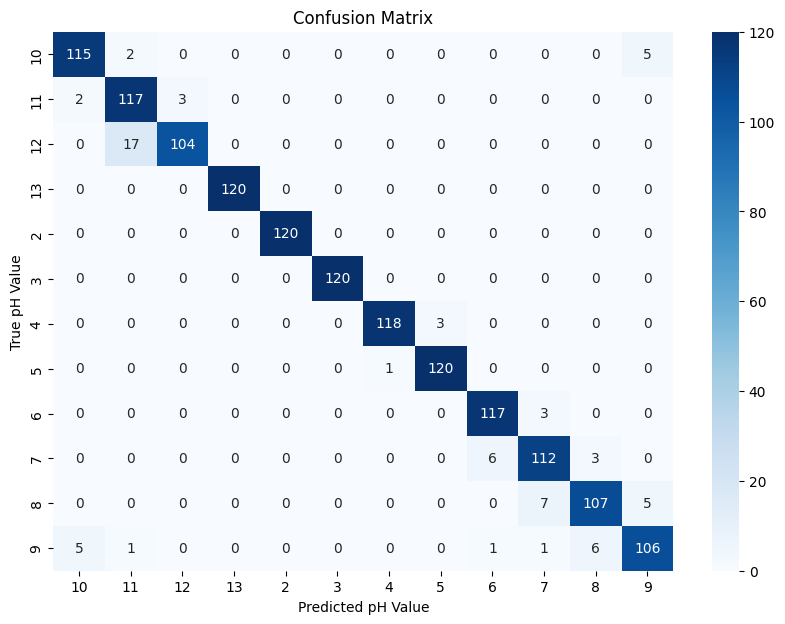

Classification Report:
               precision    recall  f1-score   support

          10       0.94      0.94      0.94       122
          11       0.85      0.96      0.90       122
          12       0.97      0.86      0.91       121
          13       1.00      1.00      1.00       120
           2       1.00      1.00      1.00       120
           3       1.00      1.00      1.00       120
           4       0.99      0.98      0.98       121
           5       0.98      0.99      0.98       121
           6       0.94      0.97      0.96       120
           7       0.91      0.93      0.92       121
           8       0.92      0.90      0.91       119
           9       0.91      0.88      0.90       120

    accuracy                           0.95      1447
   macro avg       0.95      0.95      0.95      1447
weighted avg       0.95      0.95      0.95      1447



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# --------------------------
# 1) Inference loop: collect both pred_test and true_test
# --------------------------
model.eval()
pred_test = []
true_test = []

with torch.inference_mode():
    for X_batch, y_batch in tqdm(val_dataloader, desc="Making Predictions..."):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        logits = model(X_batch)  # shape: (batch_size, num_classes)
        # get class indices; note: softmax + argmax(dim=1) is equivalent to argmax(logits, dim=1)
        preds = torch.softmax(logits, dim=1).argmax(dim=1)  # shape: (batch_size,)

        pred_test.append(preds.cpu())
        true_test.append(y_batch.cpu())

# concatenate everything into two long 1D tensors
pred_test = torch.cat(pred_test, dim=0).numpy()       # shape: (N_total_samples,)
true_test = torch.cat(true_test, dim=0).numpy()     # shape: (N_total_samples,)

# --------------------------
# 2) Compute and plot confusion matrix
# --------------------------
cm = confusion_matrix(true_test, pred_test)
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted pH Value")
plt.ylabel("True pH Value")
plt.title("Confusion Matrix")
plt.show()


# --------------------------
# 3) Classification report
# --------------------------
report = classification_report(true_test, pred_test, target_names=class_names)
print("Classification Report:\n", report)


In [ ]:
import torch

# Save
torch.save(model.state_dict(), "TinySwinTransformer_best_model.pth")

Predicted pH value: 2


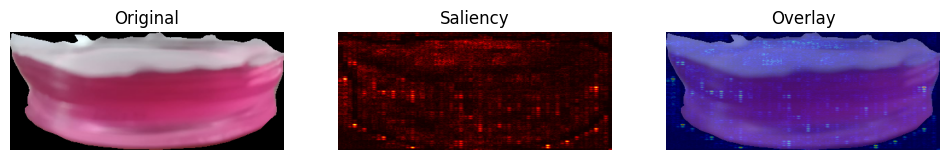

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- 1) Recreate model architecture ----
# Pastikan definisi class SwinCustomClassification ada di notebook (sama seperti saat training)
# Contoh:
# model = SwinCustomClassification(num_classes=num_classes, cfg="microsoft/swin-tiny-patch4-window7-224")

# Replace these variables with your values:
num_classes = 12                 # contoh, sesuaikan
cfg = "microsoft/swin-tiny-patch4-window7-224"
checkpoint_path = "TinySwinTransformer_best_model.pth"

# instantiate and load weights
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()

# ---- 2) Preprocessing (pakai mean/std yang dipakai waktu training) ----
RGB_mean = [0.2757323, 0.28446444, 0.33513261]
RGB_std  = [0.21059035, 0.2042752,  0.22735262]
IMG_SIZE = (227, 227)   # pakai ukuran training-mu

preprocess = T.Compose([
    T.Resize(IMG_SIZE),
    T.ToTensor(),                       # -> [0,1]
    T.Normalize(mean=RGB_mean, std=RGB_std)
])

# helper untuk menyiapkan image dan juga image untuk display (0..1)
def load_image_for_saliency(path):
    pil = Image.open(path).convert("RGB")
    disp = np.array(pil).astype(np.float32) / 255.0           # for display / overlay
    inp = preprocess(pil)                                    # normalized tensor
    inp = inp.unsqueeze(0).to(device)                        # (1, C, H, W)
    return inp, disp

# ---- 3) Compute saliency ----
def compute_saliency(model, input_tensor, target_class=None):
    # input_tensor must require grad
    input_tensor = input_tensor.clone().detach().requires_grad_(True)

    model.zero_grad()
    outputs = model(input_tensor)          # logits shape (1, num_classes)
    if isinstance(outputs, torch.Tensor):
        logits = outputs
    else:
        # if your model returns logits directly or a dict, adapt here:
        # logits = outputs.logits  or outputs['logits']
        logits = outputs

    # choose target class: predicted or provided
    if target_class is None:
        target_class = logits.argmax(dim=1).item()

    score = logits[0, target_class]       # scalar
    score.backward()

    grad = input_tensor.grad.detach().cpu()    # (1, C, H, W)
    saliency = grad.abs().squeeze(0)          # (C, H, W)
    saliency_map = saliency.sum(dim=0)        # sum over channels -> (H, W)

    # normalize to [0,1]
    sal_min, sal_max = saliency_map.min(), saliency_map.max()
    saliency_map = (saliency_map - sal_min) / (sal_max - sal_min + 1e-8)
    saliency_map_np = saliency_map.numpy()
    return saliency_map_np, target_class

# ---- 4) Overlay & show ----
def overlay_and_show(disp_img, sal_map, alpha=0.5, cmap='hot'):
    # disp_img: H,W,3 in [0,1]
    # sal_map: H,W in [0,1]
    H, W = sal_map.shape
    sal_uint8 = (sal_map * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(sal_uint8, cv2.COLORMAP_JET)   # BGR
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)         # RGB
    heatmap = heatmap.astype(np.float32) / 255.0

    overlay = (1 - alpha) * disp_img + alpha * heatmap
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(disp_img); plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Saliency")
    plt.imshow(sal_map, cmap='hot'); plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Overlay")
    plt.imshow(overlay); plt.axis('off')
    plt.show()

# ---- Example usage ----
img_path = "/content/IMG-20250202-WA0066_segmented.png"   # ganti dengan file yang kamu upload
input_tensor, disp = load_image_for_saliency(img_path)
sal_map, pred = compute_saliency(model, input_tensor, target_class=None)

class_list = ['10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']
print("Predicted pH value:", class_list[pred])

overlay_and_show(disp, cv2.resize(sal_map, (disp.shape[1], disp.shape[0])))
